In [1]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize
import statsmodels.api as sm

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0, beta0 = np.load(f)

# Setup

In [2]:
from pybaseball.lahman import batting
from pybaseball.lahman import pitching

# Get the data
batting_data = batting()
pitching_data = pitching()

# Add player's name
def add_name(ID):
    _player = _players.loc[_players.key_bbref.isin([ID]),:]
    if not _player.empty:
        try:
            fname = _player.name_first.item().capitalize() #if type(_player.name_first.item())==str  else "NaN "
            lname = _player.name_last.item().capitalize() #if type(_player.name_last.item())==str  else "NaN "
            name = fname + ' ' + lname
        except:
            print(_player)

    else:
        name = " "
    return  name

def eb_estimate(alpha0,beta0,H,AB):
    return (H+alpha0) / (AB + alpha0 + beta0)


# Get names of players
_players = pybaseball.playerid_reverse_lookup(batting_data.playerID.tolist(),key_type='bbref')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Remove unneeded columns
rows_to_keep = (batting_data.AB>0) #& (batting_data.lgID == "NL") & (batting_data.yearID > 1980)
cols_to_keep = ["AB","H","2B","3B","HR","playerID","yearID"]

# There are multiple rows for each player so group by player and get total H and AB, and take mean of years
bd = batting_data.loc[rows_to_keep ,cols_to_keep].groupby(by="playerID",as_index=True).agg({"AB": "sum", "H": "sum", "2B": "sum", "3B": "sum", "HR": "sum", "yearID": "mean"}).reset_index()#.sum().reset_index()
bd.loc[:,"yearID"] = bd.loc[:,"yearID"].astype("float")

# Add singles and non-hits to DF
bd.loc[:,"1B"] = bd.loc[:,'H'] - bd.loc[:,['2B','3B','HR']].sum(axis=1)
bd.loc[:,"Non-hit"] = bd.loc[:,'AB'] - bd.loc[:,'H']

# Add the player's name for ease of reading
bd["Name"] = bd.apply(lambda row: add_name(row.playerID),axis=1)

# Add batting average
bd["Avg"] = bd.H / bd.AB

# Add slugging percentage 
bd.loc[:,"Slg"] = (bd.loc[:,"1B"] + 2*bd.loc[:,"2B"] + 3*bd.loc[:,"3B"] + 4*bd.loc[:,"HR"])/bd.loc[:,"AB"] 

# Is pitcher?
bd.loc[:,"Pitcher"] = bd.playerID.isin(pitching_data.loc[pitching_data.G > 3,"playerID"])

# Change order
bd = bd.loc[:,["playerID","Name","yearID","AB","Non-hit","H","1B","2B","3B","HR","Avg","Slg","Pitcher"]]

# Add eb estimate
bd["Avg_eb_estimate"] = bd.apply(lambda row: eb_estimate(alpha0,beta0,row.H,row.AB),axis=1)

# Check out the DF
bd.sort_values(by="Avg_eb_estimate",ascending=False).head(10)

,playerID,Name,yearID,AB,Non-hit,H,1B,2B,3B,HR,Avg,Slg,Pitcher,Avg_eb_estimate
2932,cobbty01,Ty Cobb,1916.500000,11436,7247,4189,3053,724,295,117,0.366299,0.511892,False,0.363194
7323,hornsro01,Rogers Hornsby,1926.291667,8173,5243,2930,1919,541,169,301,0.358497,0.576532,False,0.354518
7641,jacksjo01,Shoeless joe Jackson,1914.071429,4981,3209,1772,1243,307,168,54,0.355752,0.517366,False,0.349565
760,barnero01,Ross Barnes,1875.333333,2391,1531,860,661,146,47,6,0.359682,0.467587,False,0.347142
3835,delahed01,Ed Delahanty,1895.500000,7510,4913,2597,1788,522,186,101,0.345806,0.505193,False,0.342047
14992,speaktr01,Tris Speaker,1917.500000,10195,6681,3514,2383,792,222,117,0.344679,0.500343,False,0.341915
17088,willite01,Ted Williams,1950.368421,7706,5052,2654,1537,525,71,521,0.344407,0.633792,False,0.340800
11749,odoulle01,,1927.833333,3264,2124,1140,811,175,41,113,0.349265,0.531863,True,0.340754
6426,hamilbi01,Billy Hamilton,1894.500000,6283,4119,2164,1787,242,95,40,0.344421,0.432278,False,0.340039
13812,ruthba01,Babe Ruth,1924.500000,8398,5525,2873,1517,506,136,714,0.342105,0.689807,True,0.338874


Sample 10 values from `beta` distribution given `(alpha, beta)`

In [3]:
np.random.beta(alpha0,beta0,size=10)

array([0.25306039, 0.26496387, 0.27376108, 0.27405297, 0.22222371,
       0.26049143, 0.27584536, 0.25588418, 0.27316672, 0.29880495])

Looks look at the distribution of ABs from the actual data.

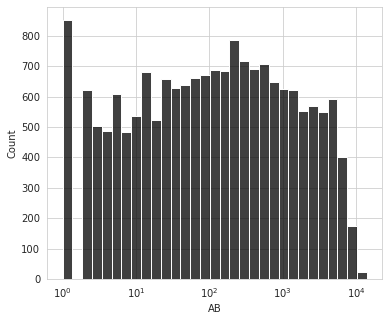

In [4]:
# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot() 
    sns.histplot(data=bd.loc[bd.AB>0,:],x="AB",log_scale=True,color='k',alpha=0.75)

## 12.2 Emperical Bayes estimation

We will start by using our actual data to compute hits based on the true ABs and the probabilities from the `beta` sampling. I am not keeping the player name since on the number of `ABs` is real data and everything else is simulated.

In [5]:
data = pd.DataFrame({"AB": bd.loc[:,"AB"].to_numpy(), "p": np.random.beta(alpha0,beta0,size=len(bd))})
data.insert(0,"H",np.random.binomial(data["AB"],data["p"]))
data


,H,AB,p
0,1,4,0.278118
1,3340,12364,0.272601
2,238,944,0.245109
3,1,5,0.264600
4,5,21,0.330677
...,...,...,...
17588,239,795,0.271818
17589,4,18,0.291742
17590,110,491,0.265767
17591,32,142,0.226974


In [6]:
# Add eb estimate
data["Avg_eb_estimate"] = data.apply(lambda row: eb_estimate(alpha0,beta0,row.H,row.AB),axis=1)
data["Avg_emperical"] = data["H"] / data["AB"]
data

,H,AB,p,Avg_eb_estimate,Avg_emperical
0,1,4,0.278118,0.260082,0.250000
1,3340,12364,0.272601,0.269869,0.270139
2,238,944,0.245109,0.254281,0.252119
3,1,5,0.264600,0.259339,0.200000
4,5,21,0.330677,0.258930,0.238095
...,...,...,...,...,...
17588,239,795,0.271818,0.288397,0.300629
17589,4,18,0.291742,0.258315,0.222222
17590,110,491,0.265767,0.238954,0.224033
17591,32,142,0.226974,0.250035,0.225352


/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_77675/3297713300.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([" "] + list(map(str,[.20,.25,.30,.35,.40])))
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_77675/3297713300.py:45: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(splot2,ticks=cbar_ticks)


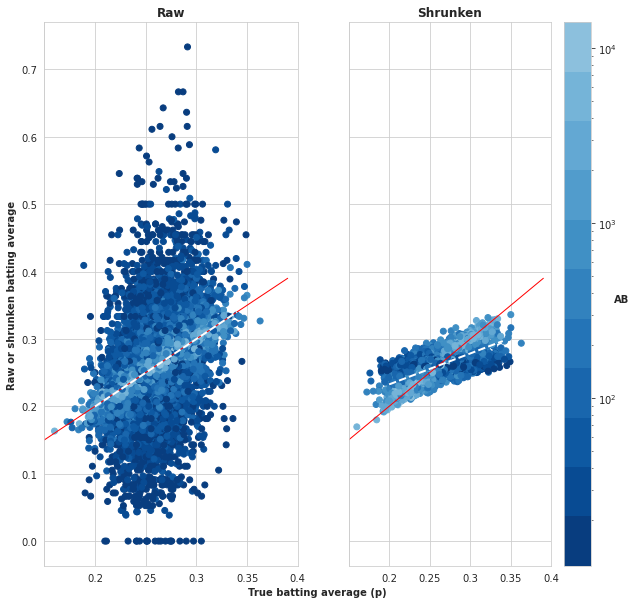

In [7]:
import matplotlib as mpl

def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result

# Regression
result1 = run_regression(data.loc[data.AB > 0, "p"],data.loc[data.AB > 0, "Avg_emperical"])
result2 = run_regression(data.loc[data.AB > 0, "p"],data.loc[data.AB > 0, "Avg_eb_estimate"])
xvals = np.arange(0.15,0.4,0.01)

with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    
    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])

    # Plot true vs emperical 
    splot1 = ax[0].scatter(data.loc[data.AB > 0, "p"],data.loc[data.AB > 10, "Avg_emperical"],c=data.loc[data.AB > 0, "AB"],cmap=cmap,norm=mpl.colors.LogNorm(),clip_on=False)
    
    # Plot best fit
    ax[0].plot(xvals,xvals,color='r',linestyle="-",lw=1)
    ax[0].plot(np.arange(.2,.35,.01),result1.predict(sm.add_constant(np.arange(.2,.35,.01))),color='white',linestyle="--",lw=2)
    
    # Plot true vs EB estimate
    splot2 = ax[1].scatter(data.loc[data.AB > 0, "p"],data.loc[data.AB > 10, "Avg_eb_estimate"],c=data.loc[data.AB > 0, "AB"],cmap=cmap,norm=mpl.colors.LogNorm())
    
    ax[1].plot(xvals,xvals,color='r',linestyle="-",lw=1)
    ax[1].plot(np.arange(.2,.35,.01),result2.predict(sm.add_constant(np.arange(.2,.35,.01))),color='white',linestyle="--",lw=2)
    
    # Clean up
    ax[0].set_xticklabels([" "] + list(map(str,[.20,.25,.30,.35,.40])))
    ax[0].set_xticks([.15,.20,.25,.30,.35,.4]) 
    ax[0].set_xlim(.15,.4)
    ax[0].set_title("Raw",fontweight="bold")
    ax[0].set_xlabel("True batting average (p)",fontweight="bold",ha="center",x=1.075,y=-.15)
    ax[0].set_ylabel("Raw or shrunken batting average",fontweight="bold")
    ax[1].set_title("Shrunken",fontweight="bold")
    cbar_ticks = [0,10,100,1000,10000]
    cbar = plt.colorbar(splot2,ticks=cbar_ticks)
    cbar.set_label("AB",rotation=0,fontweight="bold")
    

Now lets compute the mean squared error..

In [8]:
def MSE(x,y):
    return np.mean(np.square(np.subtract(x,y)))


pd.DataFrame({"Average": ["Raw","Shrunken"], "MSE": [MSE(data.Avg_emperical,data.p), MSE(data.Avg_eb_estimate, data.p)]}).set_index("Average")


,MSE
Average,
Raw,0.021376
Shrunken,0.000363


In [9]:
data["AB_binned"] = pd.cut(data.AB,pd.IntervalIndex.from_tuples([(1,10),(10,100),(100,500),(500,1000),(1000,10000)]))#pd.arrays.IntervalArray.from_tuples([(1,10),(10,100),(100,500),(500,1000),(1000,10000)]))

### Figure 12.3

Mean-squared error within bins of AB, using either the raw average or the shrunken estimate. Note that both axes are on a log scale.

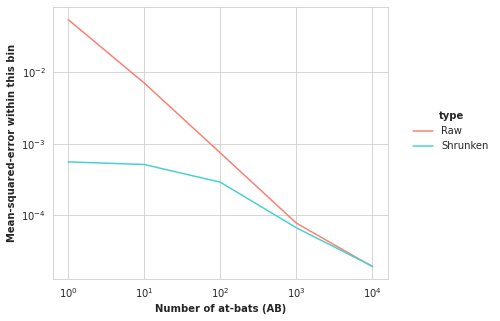

In [10]:
# Cut into bins
bins = [1,10,100,1000,10000,data.AB.max()]  
data["AB_binned"] = pd.cut(data.AB,bins=bins)

# For each bin
mse_true, mse_shrunk = [], []

for name,group in data.groupby(by="AB_binned"):
    mse_true.append(MSE(group.Avg_emperical,group.p))
    mse_shrunk.append(MSE(group.Avg_eb_estimate, group.p))

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot() 
    
    # Plot 
    ax.plot(bins[:-1],mse_true,color="salmon",label="Raw")
    ax.plot(bins[:-1],mse_shrunk,color="mediumturquoise",label="Shrunken")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax.set_ylabel("Mean-squared-error within this bin",fontweight="bold")
    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("type",prop = {'size':10,'weight': "bold"})

### Figure 12.4

Bias within bins of AB, using either the raw average or the shrunken estimate. Note that an unbiased estimate would have a slope of 0 (shown as horizontal dashed line).

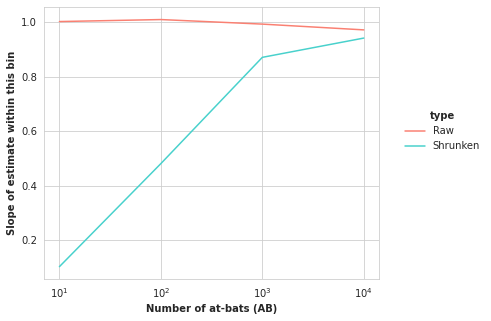

In [11]:
# Cut into bins
bins = [10,100,1000,10000,data.AB.max()]  
data["AB_binned"] = pd.cut(data.AB,bins=bins)

# Get slope for each bin
slope_true, slope_shrunk = [], []
for name,group in data.loc[data.AB >= 10,:].groupby(by="AB_binned"):
    result = run_regression(group.p,group.Avg_emperical)
    slope_true.append(result.params[1])
    result = run_regression(group.p,group.Avg_eb_estimate)
    slope_shrunk.append(result.params[1])

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot() 
    
    # Plot 
    ax.plot(bins[:-1],slope_true,color="salmon",label="Raw")
    ax.plot(bins[:-1],slope_shrunk,color="mediumturquoise",label="Shrunken")
    ax.set_xscale("log")
    ax.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax.set_ylabel("Slope of estimate within this bin",fontweight="bold")
    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("type",prop = {'size':10,'weight': "bold"})


### Figure 12.5

The relationship between the true batting average p and either the raw batting average H/AB, or the shrunken estimate pˆ , within
particular bins of AB. The red line is x = y; the dashed white line is a linear fit.


/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_77675/4103498402.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(splot,ticks=cbar_ticks,pad=.8)


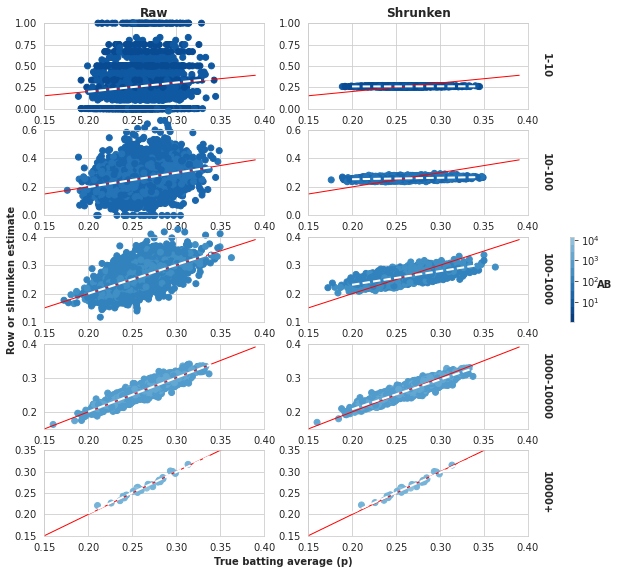

In [12]:
from dbm import whichdb


with sns.axes_style("whitegrid"):
    
    # Define figures using gridspec
    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(8,8)
    gs = fig.add_gridspec(nrows=5, ncols=2, left=.01, right=0.85, wspace=.2,hspace=.25,width_ratios=[1,1],top=.99,bottom=0.1)
    allax = []

    # fig, ax = plt.subplots(5,2,sharey=False,sharex=True)
    # fig.set_size_inches(10,10)


    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))[1:12]
    cmapbins = np.logspace(0,5,len(cmap))#np.linspace(1,data.AB.max(),len(cmap))
    # Cut into bins
    bins = [1,10,100,1000,10000,100000]  
    bin_labels = ["1-10","10-100","100-1000","1000-10000","10000+"]
    data["AB_binned"] = pd.cut(data.AB,bins=bins)

    # For each...
    which_avg = ["Avg_emperical","Avg_eb_estimate"]
    ylims = [(0,1),(0,.6),(.1,.4),(.15,.4),(.15,.35)]
    xvals1 = np.arange(0.15,0.4,0.01)
    xvals2 = np.arange(.2,.35,.01)
    for cnt0,(name,group) in enumerate(data.groupby(by="AB_binned")):
        # Get colors within range
        thiscmap = mpl.colors.ListedColormap(cmap[(cmapbins > name.left) & (cmapbins <= name.right)])
        
        for cnt1, wavg in enumerate(which_avg):        
            
            # Add axis
            thisax = fig.add_subplot(gs[cnt0,cnt1])

            # Scatterplot
            thisax.scatter(group["p"],group[wavg],c=group["AB"],cmap=thiscmap,norm=mpl.colors.LogNorm(),clip_on=False)
            result = run_regression(group["p"],group[wavg])

            # Plot regression
            thisax.plot(xvals,xvals,color='r',lw=1)
            thisax.plot(xvals2,result.predict(sm.add_constant(xvals2)),color='w',linestyle='--',lw=2)
            
            # Clean up
            thisax.set_ylim(ylims[cnt0])
            thisax.set_xlim(.15,.4)

            # Add text to right side
            if cnt1 == 1:
                thisax.text(.415,np.mean(ylims[cnt0]),bin_labels[cnt0],rotation=-90,fontweight="bold",va="center")

            # Add ax to list    
            allax.append(thisax)

        
    
    # Clean up
    allax[0].set_title("Raw",fontweight="bold")
    allax[1].set_title("Shrunken",fontweight="bold")
    allax[4].set_ylabel("Row or shrunken estimate",fontweight="bold")
    allax[-2].set_xlabel("True batting average (p)",fontweight="bold",x=1.085,y=-.05,ha="center")

    # Add colorbar
    gs0 = fig.add_gridspec(nrows=5, ncols=2, left=.01, right=0.99, wspace=.2,hspace=.25,width_ratios=[1,1],top=.99,bottom=0.1)
    hiddenax = []
    
    import itertools

    for cnt0,cnt1 in list(itertools.product([0,1,2,3,4],[0,1])):
        thisax = fig.add_subplot(gs0[cnt0,cnt1])
        thisax.set_visible(False)
        hiddenax.append(thisax)
    
    plt.sca(hiddenax[5])
    cmapfull = mpl.colors.ListedColormap(cmap)
    splot = hiddenax[5].scatter(data.loc[data.AB > 0, "p"],data.loc[data.AB > 0, "Avg_emperical"],c=data.loc[data.AB > 0, "AB"],cmap=cmapfull,norm=mpl.colors.LogNorm(),clip_on=True,visible=False)
    cbar_ticks = [0,10,100,1000,10000]  
    cbar = fig.colorbar(splot,ticks=cbar_ticks,pad=.8)    
    cbar.set_label("AB",rotation=0,fontweight="bold")


### Figure 12.6
Credible intervals for 20 randomely selected players, with the true batting average of each player shown in red.

In [13]:
data

,H,AB,p,Avg_eb_estimate,Avg_emperical,AB_binned
0,1,4,0.278118,0.260082,0.250000,"(1, 10]"
1,3340,12364,0.272601,0.269869,0.270139,"(10000, 100000]"
2,238,944,0.245109,0.254281,0.252119,"(100, 1000]"
3,1,5,0.264600,0.259339,0.200000,"(1, 10]"
4,5,21,0.330677,0.258930,0.238095,"(10, 100]"
...,...,...,...,...,...,...
17588,239,795,0.271818,0.288397,0.300629,"(100, 1000]"
17589,4,18,0.291742,0.258315,0.222222,"(10, 100]"
17590,110,491,0.265767,0.238954,0.224033,"(100, 1000]"
17591,32,142,0.226974,0.250035,0.225352,"(100, 1000]"


In [16]:
def get_credible_intervals(data,ci=[0.025,0.975]):
        # Get explicit credible intervals
        data["ci_low"], data["ci_high"] = stats.beta.ppf(ci,data["alpha1"],data["beta1"])
        # Get difference between mean and CIs since that is what matplotlib.pyplot.errorbar wants
        data["ci_low_diff"], data["ci_high_diff"] = np.absolute(data["Avg_eb_estimate"]-data["ci_low"]), np.absolute(data["Avg_eb_estimate"] - data["ci_high"])
        return data
        
# Add alpha1 and beta1 to data
data["alpha1"] = data.H + alpha0
data["beta1"]  = beta0 + (data.AB - data.H)

# Compute credible intervals
data = data.apply(get_credible_intervals,axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


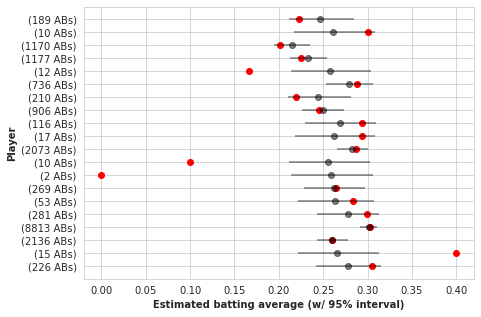

In [17]:
n_samples = 20
data_trim = data.sample(n_samples).copy()

# Get credible intervals as list of tuples
credible_intervals = data_trim.loc[:,["ci_low_diff","ci_high_diff"]].transpose().to_numpy()

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    ax.errorbar(x=data_trim.loc[:,"Avg_eb_estimate"],y=np.arange(n_samples),xerr=credible_intervals,color='k',fmt='o',alpha=0.5)
    ax.scatter(x=data_trim.loc[:,"Avg_emperical"],y=np.arange(n_samples),color='r')
    # Clean up
    # ax.set_xticks([0.20,0.24,0.28,0.32])
    ax.set_yticks(np.arange(n_samples))
    ax.set_yticklabels(["({} ABs)".format(x) for x in data_trim.AB])
    ax.set_xlabel("Estimated batting average (w/ 95% interval)",fontweight="bold")
    ax.set_ylabel("Player",fontweight="bold")
    ax.legend(frameon=False)

### Figure 12.7
Comparison of the level of the credibility interval to the percentage of players where the credible interval contains the true value.

In [18]:
# Find if avg is in credible interval
def credible_level_coverage(row):
    return (row["p"] >= row["ci_low"]) & (row["p"] <= row["ci_high"])
        

credible_levels = list(zip(0.5 - (np.arange(0.5,0.98,0.02))/2, 0.5 + (np.arange(0.5,1,0.02))/2))

coverage = []
for levels in credible_levels:
    # Compute credible intervals
    data = data.apply(lambda row: get_credible_intervals(row, list(levels)),axis=1)
    # Determine if is in interval
    in_interval = data.apply(lambda row: credible_level_coverage(row), axis=1)
    # Add to list
    coverage.append(in_interval.sum() / len(in_interval))

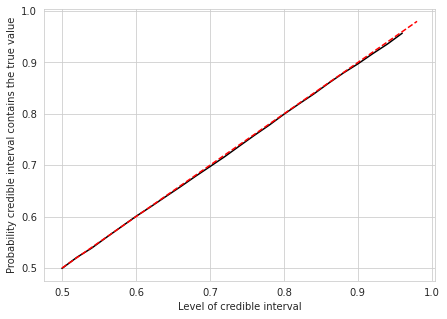

In [19]:
# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    ax.plot(np.arange(0.5,0.98,0.02),coverage,color='k',linestyle='-')
    ax.plot(np.arange(0.5,1,0.02),np.arange(0.5,1,0.02),color='r',linestyle='--')
    ax.set_xlabel("Level of credible interval")
    ax.set_ylabel("Probability credible interval contains the true value")
    

### Figure 12.8 
Comparison of the q- value threshold, meant to control false discovery rate, and the true FDR, defined as the number of players included where p < 3. The red line is x = y.

In [20]:
def calculate_PEP(row,q=0.3):
        # Get explicit credible intervals
        row["PEP"] = stats.beta.cdf(q,row["alpha1"],row["beta1"])
        return row

data = data.apply(lambda row: calculate_PEP(row,q=0.3),axis=1)

In [21]:
data_sorted = data.sort_values(by="PEP").reset_index()
data_sorted["q_value"] = data_sorted.PEP.expanding().mean()


In [22]:
hall_of_fame = data_sorted.loc[data_sorted.q_value <= 0.1, :]
print("% players included in hall of fame incorrectly for q-value threshold of 10%: {:.1f}%".format(100*(hall_of_fame.p < 0.3).sum()/len(hall_of_fame)))

% players included in hall of fame incorrectly for q-value threshold of 10%: 11.9%


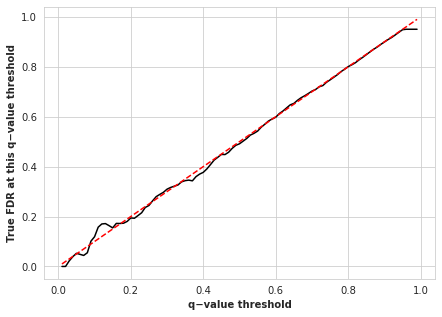

In [23]:
true_FDR = []
q_values = np.arange(0.01,1,0.01)
for q_val in q_values:
    hall_of_fame = data_sorted.loc[data_sorted.q_value <= q_val, :]
    true_FDR.append((hall_of_fame.p < 0.3).sum()/len(hall_of_fame))


# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    ax.plot(q_values,true_FDR,color='k',linestyle='-')
    ax.plot(q_values,q_values,color='r',linestyle='--')
    ax.set_xlabel("q−value threshold",fontweight="bold")
    ax.set_ylabel("True FDR at this q−value threshold",fontweight="bold")
    

## 12.5 Beta-binomial regression
Now lets consider how well the beta-binomial method captured the AB trend in the data. We will reuse a bunch of code from Ch.7

In [32]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    # Get H/AB 
    k, n = args # H, AB

    # The initial model assumed a fixed (alpha, beta):
    #        a, b = params[0], params[1]

    # Here, we take in the initial values of (mu_0, mu_ab, and sigma_0) to compute (alpha, beta):
    mu_0, mu_AB, sigma_0 = params
    mu_i = mu_0 + mu_AB*np.log(n)
    a = mu_i / sigma_0
    b = (1-mu_i)/sigma_0
    
    # Log pdf
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf) #

from scipy.optimize import minimize

min_atbat = 0

# I am going to cheat here and use the values from the book as initial parameters since MLE is probably not the best choice here.
init_params = [-1.68767,.19232,np.exp(-6.2935)]

# note that I am putting 'H' in the args
result = minimize(loglike_betabinom, x0=init_params,
            args=(data.H, data.AB),
            method='L-BFGS-B', options={'disp': False, 'maxiter': 10000},bounds=[(-2,2), (0.001, 0.5),(.0001,.1)])
            
print(result)


      fun: -21393320.842581686
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.60431149e+06, 4.45347976e+07, 1.87908935e+10])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 220
      nit: 6
     njev: 55
   status: 0
  success: True
        x: array([-1.99999992e+00,  1.00000000e-03,  1.00016604e-04])


In [24]:
def new_eb_estimate(row,params):

    # Get H and AB for each row
    H,AB = row.H, row.AB
    
    # Get values from MLE results
    mu, mu_AB, sigma = params

    # Update alpha0 and beta0
    mu_i = (mu + mu_AB*np.log(AB)) if AB > 0 else mu
    a = mu_i / sigma
    b = (1-mu_i)/sigma
    alpha0 = mu_i/sigma
    beta0 = (1-mu_i)/sigma

    # Update alpha1 and beta1
    alpha1 = alpha0 + H
    beta1  = beta0 + (AB - H)

    # New eb estimate
    new_eb_estimate = alpha1 / (alpha1 + beta1)

    # Update data
    row["alpha0_bbr"] = alpha0 
    row["beta0_bbr"]  = beta0 
    row["alpha1_bbr"] = alpha1
    row["beta1_bbr"]  = beta1
    row["new_eb_estimate_bbr"] = new_eb_estimate

    return row

# data = data.loc[data.AB>0,:].apply(lambda row: new_eb_estimate(row,result.x),axis=1)

In [ ]:
import pymc as pm
import arviz as az

n_samples = 30000
H,AB = data.loc[:,"H"].to_numpy(), data.loc[:,"AB"].to_numpy()
# Create the probability from the logistic function
with pm.Model() as model1:
    # Define parameters for mu, mu_ab
    mu_0 = pm.Uniform('mu_o', lower=0.0, upper=1.0)
    mu_ab = pm.Uniform('mu_ab', lower=0.0, upper=1.0)
    # Kappa => 1/sigma
    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', pm.math.exp(kappa_log))

    # Get beta-binomial models
    X1 = pm.BetaBinomial('X', alpha=(mu_0+ mu_ab * pm.math.log(AB))*kappa, beta=(1-(mu_0 + mu_ab * pm.math.log(AB)))*kappa, n=AB, observed=H, shape=AB.shape[0])
    # Sample!
    idata1 = pm.sample(n_samples, init="advi+adapt_diag")

mu_mcmc    = idata1.posterior["mu_o"].mean(("chain","draw")).to_numpy()
mu_ab_mcmc = idata1.posterior["mu_ab"].mean(("chain","draw")).to_numpy()
sigma_mcmc = 1/idata1.posterior["kappa"].mean(("chain","draw")).to_numpy()
print(mu_mcmc,mu_ab_mcmc,sigma_mcmc)

data = data.loc[data.AB>0,:].apply(lambda row: new_eb_estimate(row,(mu_mcmc,mu_ab_mcmc,sigma_mcmc)),axis=1)


In [31]:
data

,H,AB,p,Avg_eb_estimate,Avg_emperical,AB_binned,alpha1,beta1,ci_low,ci_high,...,alpha0_bbr,beta0_bbr,alpha1_bbr,beta1_bbr,new_eb_estimate_bbr,alpha0_bbr_mle,beta0_bbr_mle,alpha1_bbr_mle,beta1_bbr_mle,new_eb_estimate_bbr_mle
0,1,4,0.278118,0.260082,0.250000,"(1.0, 10.0]",90.733185,258.130635,0.213445,0.309668,...,88.804386,253.629936,89.804386,256.629936,0.259225,-19982.818335,29981.158213,-19981.818335,29984.158213,-1.997714
1,3340,12364,0.272601,0.269869,0.270139,"(10000.0, 100000.0]",3429.733185,9279.130635,0.261822,0.277994,...,89.083806,253.350516,3429.083806,9277.350516,0.269870,-19902.469177,29900.809055,-16562.469177,38924.809055,-0.740641
2,238,944,0.245109,0.254281,0.252119,"(100.0, 1000.0]",327.733185,961.130635,0.229796,0.279583,...,88.994363,253.439959,326.994363,959.439959,0.254187,-19928.189088,29926.528966,-19690.189088,30632.528966,-1.799450
3,1,5,0.264600,0.259339,0.200000,"(1.0, 10.0]",90.733185,259.130635,0.212815,0.308812,...,88.812145,253.622177,89.812145,257.622177,0.258501,-19980.587270,29978.927148,-19979.587270,29982.927148,-1.997292
4,5,21,0.330677,0.258930,0.238095,"(10.0, 100.0]",94.733185,271.130635,0.213425,0.307261,...,88.862043,253.572279,93.862043,269.572279,0.258264,-19966.238808,29964.578685,-19961.238808,29980.578685,-1.992271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17588,239,795,0.271818,0.288397,0.300629,"(100.0, 1000.0]",328.733185,811.130635,0.261259,0.316331,...,88.988390,253.445932,327.988390,809.445932,0.288358,-19929.906643,29928.246521,-19690.906643,30484.246521,-1.824357
17589,4,18,0.291742,0.258315,0.222222,"(10.0, 100.0]",93.733185,269.130635,0.212669,0.306818,...,88.856683,253.577639,92.856683,267.577639,0.257624,-19967.780058,29966.119936,-19963.780058,29980.119936,-1.993121
17590,110,491,0.265767,0.238954,0.224033,"(100.0, 1000.0]",199.733185,636.130635,0.209364,0.269884,...,88.971635,253.462687,198.971635,634.462687,0.238737,-19934.724823,29933.064701,-19824.724823,30314.064701,-1.889988
17591,32,142,0.226974,0.250035,0.225352,"(100.0, 1000.0]",121.733185,365.130635,0.210906,0.291367,...,88.928499,253.505823,120.928499,363.505823,0.249628,-19947.128934,29945.468812,-19915.128934,30055.468812,-1.963951


/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_77675/3181112379.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([" "] + list(map(str,[.20,.25,.30,.35,.40])))
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_77675/3181112379.py:45: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(splot2,ticks=cbar_ticks)


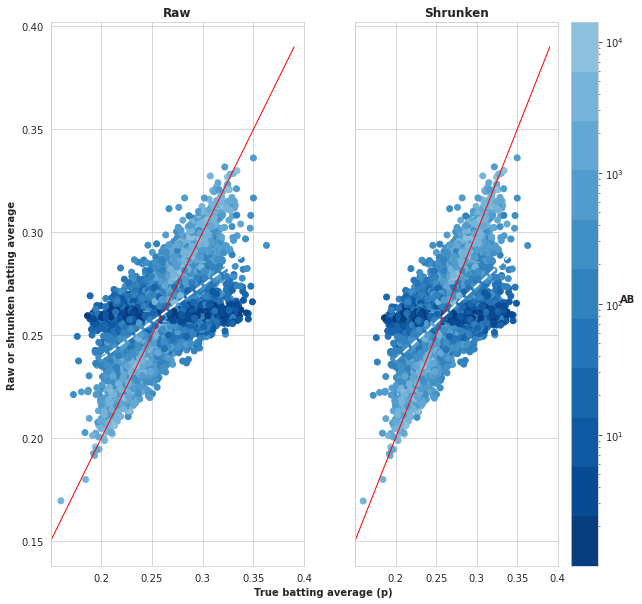

In [37]:
import matplotlib as mpl

def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result

# Regression
result1 = run_regression(data.loc[data.AB > 0, "p"],data.loc[data.AB > 0, "Avg_eb_estimate"])
result2 = run_regression(data.loc[data.AB > 0, "p"],data.loc[data.AB > 0, "new_eb_estimate_bbr"])
xvals = np.arange(0.15,0.4,0.01)

with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    
    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])

    # Plot true vs emperical 
    splot1 = ax[0].scatter(data.loc[data.AB > 0, "p"],data.loc[data.AB > 0, "Avg_eb_estimate"],c=data.loc[data.AB > 0, "AB"],cmap=cmap,norm=mpl.colors.LogNorm(),clip_on=False)
    
    # Plot best fit
    ax[0].plot(xvals,xvals,color='r',linestyle="-",lw=1)
    ax[0].plot(np.arange(.2,.35,.01),result1.predict(sm.add_constant(np.arange(.2,.35,.01))),color='white',linestyle="--",lw=2)
    
    # Plot true vs EB estimate
    splot2 = ax[1].scatter(data.loc[data.AB > 0, "p"],data.loc[data.AB > 0, "new_eb_estimate_bbr"],c=data.loc[data.AB > 0, "AB"],cmap=cmap,norm=mpl.colors.LogNorm())
    
    ax[1].plot(xvals,xvals,color='r',linestyle="-",lw=1)
    ax[1].plot(np.arange(.2,.35,.01),result2.predict(sm.add_constant(np.arange(.2,.35,.01))),color='white',linestyle="--",lw=2)
    
    # Clean up
    ax[0].set_xticklabels([" "] + list(map(str,[.20,.25,.30,.35,.40])))
    ax[0].set_xticks([.15,.20,.25,.30,.35,.4]) 
    ax[0].set_xlim(.15,.4)
    ax[0].set_title("Raw",fontweight="bold")
    ax[0].set_xlabel("True batting average (p)",fontweight="bold",ha="center",x=1.075,y=-.15)
    ax[0].set_ylabel("Raw or shrunken batting average",fontweight="bold")
    ax[1].set_title("Shrunken",fontweight="bold")
    cbar_ticks = [0,10,100,1000,10000]
    cbar = plt.colorbar(splot2,ticks=cbar_ticks)
    cbar.set_label("AB",rotation=0,fontweight="bold")
    

Not quite sure why this is not coming out right...

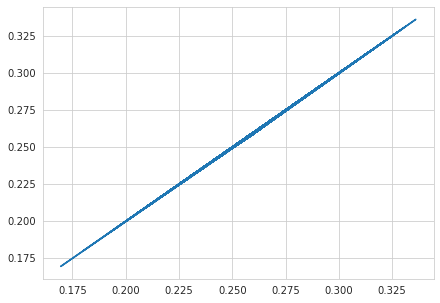

In [38]:
# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    ax.plot(data.Avg_eb_estimate,data.new_eb_estimate_bbr)